# Finding the next 8Bn

This notebook is for working out the timescales for the next 8 bn.

We have to do some (very basic) modelling to extend out the forecast to estimate when some of them will hit 8Bn, with an open question over the UNPD Low scenario

In [12]:
from matplotlib import pyplot as plt
from pandas import DataFrame, concat, read_csv
from statsmodels.tsa.ar_model import AutoReg

import seaborn as sns
import os

In [13]:
""" Data paths
"""

prepped_data_root = "../../data/prepared_data"

unpd_world_path = os.path.join(prepped_data_root,"unpd_world_indicators.csv")
gbd_world_births_path = os.path.join(prepped_data_root,"gbd_world_births.csv")

In [14]:
""" Functions for extending projections on the basis of an AR(N) model
"""

def df_extender(df, **cols_to_input):
    ''' Generate a dataframe that extends the input

        df: original dataframe
        cols_to_input: key/val of colnames, lists of data

        everything not in cols_to_input is copied from first val
    '''
    new_cols = [c for c in df.columns if c not in cols_to_input.keys()]
    base_df = DataFrame(cols_to_input,
            columns=df.columns)
    for col in new_cols:
        base_df[col] = df[col].iloc[0]

    return base_df

def extend_ar(grouped_df,
        lags,
        values_col="val",
        year_col="year_id",
        extrapolation_length=10):
    ''' Take a DF grouped by the scenario so we have a single timeseries
        and add an extra @n steps using an AR(lags) model
        don't rely on this for a long extrapolation with further analysis
    '''
    ts_len, df_cols = grouped_df.shape
    final_year_df = grouped_df[year_col].max()
    final_year_predict = final_year_df + extrapolation_length
    new_years = [year for year in range(final_year_df+1, final_year_predict+1)]

    ar_model = AutoReg(grouped_df[values_col].to_numpy(), lags=lags).fit()
    new_datapoints = ar_model.predict(ts_len, ts_len+extrapolation_length-1)
    new_fields = {values_col: new_datapoints, year_col: new_years}

    return concat([grouped_df, 
        df_extender(grouped_df, **new_fields)]
        )


In [31]:
""" Load in the data sets
"""

df_unpd = read_csv(unpd_world_path)
df_unpd = df_unpd[df_unpd.Time < 2101] # I dislike overwriting but 2101 seems to be there but null in this dataset

df_gbd = read_csv(gbd_world_births_path)

In [32]:
print(f"UNPD:\n{df_unpd.columns}\n\nGBD\n{df_gbd.columns}")

UNPD:
Index(['Unnamed: 0', 'SortOrder', 'LocID', 'Notes', 'ISO3_code', 'ISO2_code',
       'SDMX_code', 'LocTypeID', 'LocTypeName', 'ParentID', 'Location',
       'VarID', 'Variant', 'Time', 'TPopulation1Jan', 'TPopulation1July',
       'TPopulationMale1July', 'TPopulationFemale1July', 'PopDensity',
       'PopSexRatio', 'MedianAgePop', 'NatChange', 'NatChangeRT', 'PopChange',
       'PopGrowthRate', 'DoublingTime', 'Births', 'Births1519', 'CBR', 'TFR',
       'NRR', 'MAC', 'SRB', 'Deaths', 'DeathsMale', 'DeathsFemale', 'CDR',
       'LEx', 'LExMale', 'LExFemale', 'LE15', 'LE15Male', 'LE15Female', 'LE65',
       'LE65Male', 'LE65Female', 'LE80', 'LE80Male', 'LE80Female',
       'InfantDeaths', 'IMR', 'LBsurvivingAge1', 'Under5Deaths', 'Q5', 'Q0040',
       'Q0040Male', 'Q0040Female', 'Q0060', 'Q0060Male', 'Q0060Female',
       'Q1550', 'Q1550Male', 'Q1550Female', 'Q1560', 'Q1560Male',
       'Q1560Female', 'NetMigrations', 'CNMR', 'BirthsSingle'],
      dtype='object')

GBD
Index(['Unn

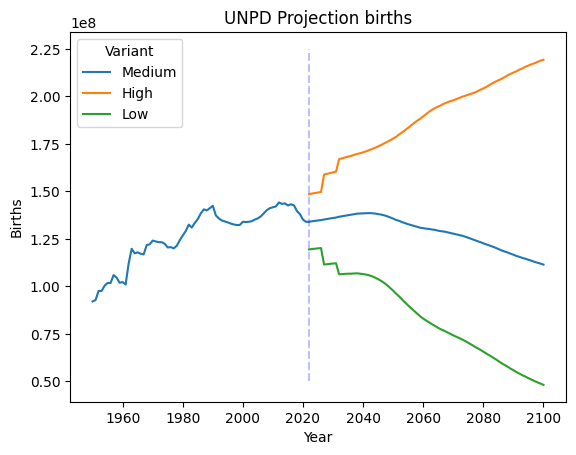

In [33]:
sns.lineplot(data=df_unpd, x="Time", y="BirthsSingle", hue="Variant")
plt.title("UNPD Projection births")
plt.xlabel("Year")
plt.ylabel("Births")
plt.vlines(2022, 0.5e8, 2.25e8, color="b",linestyle="dashed", alpha=0.25)
plt.show()

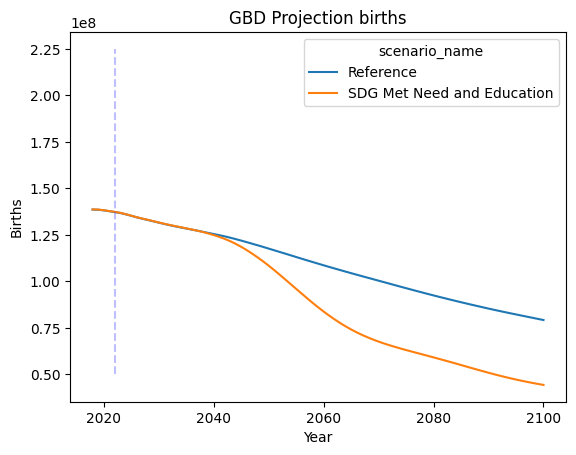

In [34]:
sns.lineplot(data=df_gbd, x="year_id", y="val", hue="scenario_name")
plt.title("GBD Projection births")
plt.xlabel("Year")
plt.ylabel("Births")
plt.vlines(2022, 0.5e8, 2.25e8, color="b",linestyle="dashed", alpha=0.25)
plt.show()

In [35]:
df_unpd.groupby("Scenario").BirthsSingle.sum

,Unnamed: 0,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,LocTypeName,ParentID,...,Q0060Female,Q1550,Q1550Male,Q1550Female,Q1560,Q1560Male,Q1560Female,NetMigrations,CNMR,BirthsSingle
